# Trabalho: Competição de Carros Autônomos em Simuladores de Jogos

## 1.1 - Equipes

- As equipes serão formadas por grupos de:
    - projetistas (4º Período) responsáveis por implementar os modelos matemáticos (EDO's) que descrevem a cinemática dos veículos e analisar a precisão e a trajetória dos seus movimentos em ambiente computacional Matlab/Octave tendo como base os conhecimentos adquiridos na disciplina de Cálculo Numérico.
    - programadores (2º Período) responsáveis por implementar em C++ o controlador conhecido como Pure Pursuit disponibilizado pelo professor em Matlab/Octave para que o veículo simulado siga uma trajetória de pontos na pista respeitando a velocidade estipulada em cada ponto. A trajetória será gerada (salva) pelos integrantes do grupo ao dirigir o veículo em modo manual e salvar as posições e velocidades correntes a cada metro.

## 1.2 - Regras

- Dirigir o carro manualmente no ambiente simulado do Microsoft Airsim e salvar num arquivo waypoints.csv as coordenadas x,y por onde o carro passou e a velocidade que estava. Devem ser salvos quatro arquivos com pontos cujas distâncias estejam 1m, 3m e 5m uns dos outros e um original com todas as coordenadas por onde o carro passou.
- Posteriormente, ler o arquivo waypoints.csv e interpolar os pontos (waypoints) para preencher o espaço vazio deixado no intervalo de 1m, 3m e 5m.
- Passar os pontos interpolados para o controlador Pure Pursuit repetir o trajeto de forma autonoma
- Medir o erro da trajetória executada para a original considerando as diferentes interpolações de 1m, 3m e 5m.
- Rodar o simulador com 10, 20 e 30 FPS, ou seja dt=1/FPS, e medir o erro da trajetória novamente
- O ranking será formado pelas equipes que obtiverem o menor erro e o menor tempo para completar o percurso  pré-estabelecido de waypoints de 3m a 30 FPS.
- Para se classificar as equipes deverão passar por pelo menos 50% dos pontos (waypoints).

## 2 - Introdução

### 2.1 - Modelo Cinemático de Robôs com Direção Diferencial

(O modelo cinemático de robôs com direção diferencial apresentado neste trabalho foi traduzido de http://rossum.sourceforge.net/papers/DiffSteer/)

Analisaremos neste trabalho as equações que descrevem a trajetória de um robô ou veículo equipado com um sistema de direção diferencial. Este sistema é comumente usado em robôs menores também conhecido como modelo do monociclo. Possui geralmente duas rodas montadas em um único eixo que são alimentadas e controladas de forma independente, fornecendo funções de acionamento e direção. As equações utilizadas neste trabalho fornecem um modelo básico para o sistema de acionamento com direção diferencial (geralmente chamado de sistema de direção diferencial). Este modelo pode ser usado para prever como um robô equipado com esse sistema responderá a mudanças na velocidade da roda e qual caminho seguirá sob várias condições. O modelo também pode ser usado para calcular a posição de um robô por meio de odometria (técnicas que estimam a posição de um robô com base nas distâncias medidas com os dispositivos de odômetros montados em cada roda).

Vale ressaltar que as equações apresentadas aqui representam um modelo básico para o movimento de um robô. Elas descrevem a posição e a orientação do robô em função do movimento de suas rodas, mas ignoram a física subjacente envolvida na realização desse movimento. Questões associadas a torque, forças, atrito, energia e inércia não serão consideradas. Em termos técnicos, esse método de descrição de movimento é chamado de abordagem cinemática, pois ignora as causas do movimento (que seriam estudadas em uma abordagem dinâmica) e foca nos efeitos. Como tal, elas fornecem um primeiro passo para entender o comportamento dos robôs com sistemas de direção diferencial, e não uma descrição completa.

#### 2.1.1 - O Modelo do Robô Diferencial

<img src="img/fig4_14.svg" width="50%" height="50%">

O modelo de direção diferencial usado em muitos robôs é essencialmente o mesmo arranjo usado em uma cadeira de rodas. Portanto, a maioria de nós tem uma compreensão intuitiva do seu modo de funcionamento. Se ambas as rodas motrizes girarem no mesmo sentido, o robô se moverá em linha reta. Se uma roda girar mais rápido que a outra, o robô segue um caminho curvilineo para dentro em direção à roda mais lenta. Se as rodas girarem na mesma velocidade, mas em direções opostas, o robô gira em torno do prórpio eixo. Assim, dirigir o robô é apenas uma questão de variar as velocidades das rodas motrizes. Mas como exatamente escolhemos as velocidades para que o robô se mova para onde queremos que ele vá? Neste trabalho, buscaremos refinar esse entendimento intuitivo em expressões matemáticas que podem ser usadas para implementar o software de controle de robôs.

#### 2.1.2 - Fazendo uma Curva

Antes de abordar o modelo de direção diferencial, vamos considerar o problema de fazer com que um robô faça uma curva de 90 graus em uma esquina de um corredor ou de uma estrada. Uma abordagem simples é fazer o robô dirigir até o cruzamento, parar e girar. Claramente, porém, essa abordagem é ineficiente e um pouco desajeitada. Uma abordagem mais elegante seria o robô dobrar a esquina , seguindo um arco circular gradual através do cruzamento, mantendo uma velocidade constante. Para atingir esse objetivo, aumentamos a velocidade da roda externa enquanto diminuímos a velocidade da roda interna.
O caminho que o robô segue é verdadeiramente circular ou é algum outro tipo de curva? Mais adiante, mostraremos que, se ambas as rodas girarem em velocidades constantes, mas diferentes, o robô seguirá um caminho circular. Por enquanto, apenas assuma que o caminho é circular. Com isso em mente, vemos que as velocidades das rodas são selecionadas com base na rotação que desejamos que o robô faça.


#### Figura 1. Trajeto das rodas em uma curva.

<img src="img/diff_drive.gif" width="25%" height="25%">

Referindo-se à Figura 1, observe os relacionamentos:
$$S_L=r\theta\\S_R=(r+b)\theta\\S_M=(r+\frac{b}{2})\theta$$

Onde, $S_L,S_R$ indicam o deslocamento (distância percorrida) das rodas esquerda e direita, respectivamente. E $r$ é o raio da trajetória para a roda interna (esquerda), $b$ é a distância entre as rodas (de centro a centro ao longo do comprimento do eixo), e $\theta$ é o ângulo da curva em radianos. $S_M$ é a velocidade no ponto central do eixo principal. Nesta discussão, trataremos o ponto central do eixo como a origem do sistema de referência do robô simulado.


#### 2.1.3 - Preliminares e Premissas

Depois que estabelecemos a geometria simples para o sistema de direção diferencial, é fácil desenvolver algoritmos para controlar o caminho do robô. Note, no entanto, que fizemos uma importante suposição simplificadora: as rodas mantêm uma velocidade constante. Negligenciamos os efeitos da aceleração. Se as rodas puderem acelerar, a curva que descreve a trajetória do robô pode se tornar muito mais complicada. Ao trabalhar com robôs muito leves, onde a massa (e inércia) da plataforma é pequena, geralmente podemos tratar as mudanças de velocidade quase instantaneamente. O caminho que o robô segue não será verdadeiramente circular, mas estará próximo o suficiente para muitas aplicações. Para robôs maiores e mais pesados, é claro, a massa é importante e a aceleração deve ser considerada. 

Na discussão acima, consideramos o problema de tentar escolher as velocidades das rodas com base no caminho desejado. Agora consideraremos o problema oposto: como encontrar a trajetória do robô se formos informados a que velocidade as rodas devem girar? A resposta a essa pergunta leva ao desenvolvimento de nosso modelo e também se aplica diretamente ao cálculo de odometria. Essencialmente, esse é um problema conhecido como cinemática direta, ou seja, a técnica de prever o comportamento de um sistema mecânico com base nas entradas desse sistema.

Desenvolver um modelo para o sistema de direção diferencial não é difícil, mas requer o uso de cálculo e equações diferenciais. Se você não está familiarizado com o cálculo, pode preferir apenas visualizar os resultados apresentados nas equações (3) e (5) abaixo.

Para começar, considere que o que realmente interessa é como as coordenadas $x$ e $y$ (e orientação) mudam com relação ao tempo. A qualquer momento, as coordenadas $x$ e $y$ do ponto central do robô estão mudando com base em sua velocidade e orientação. Tratamos a orientação como um ângulo $q$ medido em radianos, no sentido anti-horário em relação ao eixo x. Lembre-se de que o vetor que indica a direção do movimento para frente do robô será simplesmente $(cos(\theta), sen(\theta))$. As coordenadas $x$ e $y$ para o ponto central do robô mudarão dependendo da velocidade do seu movimento ao longo desse vetor.

Essas observações sugerem que, considerando $v(t)=\frac{v_R(t) + v_L(t)}{2}$, $w(t)=v_R(t)-v_L(t)$ e $\theta(t)$ como funções dependentes do tempo para a velocidade e a orientação do robô, nossa solução terá o seguinte sistema de EDO's (1):

$$\frac{dx}{dt}=v(t)cos(\theta)\\\frac{dy}{dt}=v(t)sen(\theta)\\\frac{d\theta}{dt}=\frac{w(t)}{b}$$

#### 2.1.4 - Derivando o modelo

Vamos derivar funções para a trajetória do robô. Por enquanto, será mais fácil ignorar o pensamento sobre aceleração e assumir que as velocidades das rodas são constantes. Se as duas rodas estão se movendo na mesma velocidade, o robô viaja em linha reta e a equação para sua trajetória é trivial. Portanto, consideraremos o caso em que as rodas viajam em velocidades diferentes.

Referindo-se à figura 2, observe que, à medida que o robô muda de posição, todos os pontos do robô podem estar em movimento. Para desenvolver uma equação cinemática direta para o movimento de um sistema de direção diferencial, começamos especificando um sistema de referência no qual um ponto escolhido arbitrariamente é tratado como estacionário. Todos os outros pontos do sistema são tratados como se movendo em relação ao ponto de referência. O robô é considerado um corpo rígido. Ao abordar o problema dessa maneira, obteremos informações que podem ser aplicadas ao problema mais geral de modelar o movimento do robô em um sistema de referência absoluto.

#### Figura 2. Rodas em diferentes velocidades.
<img src="img/diff_drive2.gif" width="25%" height="25%">

O ponto que selecionamos como referência é o ponto central da roda esquerda. Este é o ponto em que uma roda ideal faz contato com o piso. Novamente, todo movimento nesse sistema de referência é tratado em relação ao ponto da roda esquerda. Como a roda direita é montada perpendicularmente ao eixo, seu movimento dentro do sistema de referência segue um arco circular com um raio correspondente ao comprimento do eixo.

Agora, o próprio ponto central pode estar em movimento, de modo que o caminho real da roda direita não corresponderá necessariamente a esse arco circular específico. Mas a mudança de orientação $\theta$ não está restrita ao sistema de referência do robô. Como tratamos o robô como um corpo rígido, todos os pontos do sistema sofrem a mesma mudança de orientação. Se girarmos o robô 10 graus sobre a roda esquerda, todos os pontos sofrerão uma mudança de 10 graus na orientação. E qualquer mudança na orientação do sistema de referência especial é, de fato, equivalente à do caso mais geral.

Com base nessas observações, podemos derivar uma equação diferencial que descreve a mudança na orientação em relação ao tempo. A definição de um ângulo dado em radianos é o comprimento de um arco circular dividido pelo raio desse círculo. A velocidade relativa da roda direita nos dá esse comprimento de arco por unidade de tempo. O comprimento da roda até o ponto central nos dá o raio. Combinando esses fatos, temos (2):

$$\frac{d\theta}{dt}=\frac{(v_R - v_L)}{b}$$

Integrando (2) e tomando a orientação inicial do robô como $\theta(0)=\theta_0$ , encontramos uma função para calcular a orientação do robô em função do tempo e da velocidade da roda (3):

$$\theta(t)=\frac{(v_R - v_L)t}{b}+\theta_0$$

Como observado acima, essa mudança de orientação também se aplica ao sistema de referência absoluto. Voltando nossa atenção ao sistema absoluto, lembramos de (1) acima que o movimento geral do robô depende da velocidade do seu ponto central (o ponto médio do eixo). Essa velocidade é simplesmente a média para as duas rodas, ou $(v_R + v_L)/2$. Combinamos esse fato com o que sabemos sobre orientação em função do tempo e obtemos as seguintes equações diferenciais:

$$\frac{dx}{dt}=\frac{(v_R + v_L)t}{2}cos(\theta(t))\\\frac{dy}{dt}=\frac{(v_R + v_L)t}{2}sen(\theta(t))$$

Observe que as equações em (4) estão na mesma forma que a mostrada em (1). Integrando e aplicando a posição inicial do robô $x(0)=x_0$ e $y(0)=y_0$, temos (5):

$$x(t)=x_0+\frac{b(v_R + v_L)}{2(v_R - v_L)} \left[sen(\frac{(v_R - v_L)t}{b}+\theta_0)-sen(\theta_0)\right]\\
y(t)=y_0-\frac{b(v_R + v_L)}{2(v_R - v_L)} \left[cos(\frac{(v_R - v_L)t}{b}+\theta_0)-cos(\theta_0)\right]$$

Observe que as equações fornecidas em (5) confirmam a afirmação anterior de que, quando as rodas giram em velocidades fixas, o robô segue um caminho circular. O termo $\frac{b(v_R + v_L)}{2(v_R - v_L)}$ é na verdade o raio de curvatura para a trajetória circular do centro do robô.

#### 2.1.5 - Seguindo em linha "reta"

Ao usar (5) em um programa de computador, é necessário implementar um tratamento especial nos casos em que as velocidades das rodas são quase iguais e $$(v_R - v_L) \approx 0$$

In [1]:
% Escreva o comando para verificar esse tratamento especial


Nesses casos, é claro, o robô viaja em uma linha quase reta. Usando a regra de L'Hospital do cálculo elementar, podemos mostrar que as equações têm limites que se aproximam de uma linha reta na direção da orientação inicial $\theta_0$ .

In [2]:
% Reescreva as equações considerando que o robô se move numa trajetória retilínea


#### 2.1.6 - Solução Numerica via EDO's

In [3]:
L = 1; % Wheel separation [m] (default 1)
dt = 0.1; % Time interval (default 0.1)
speedmax = 5; % Maximum speed (default 5m/s)
accelmax = Inf;

In [4]:
addpath('src/trabalho')
uni = unicycle(L, dt, speedmax, accelmax)

Unicycle: uni = <L=1.000000, dt=0.100000, vmax=5.000000, amax=Inf>


In [5]:
% Pag. 123
x = [0 0 0]; 
u = [0.3, 0.2];
x1 = kinematics(uni, [], x, u)

x1 =

   0.30000
   0.00000
   0.20000



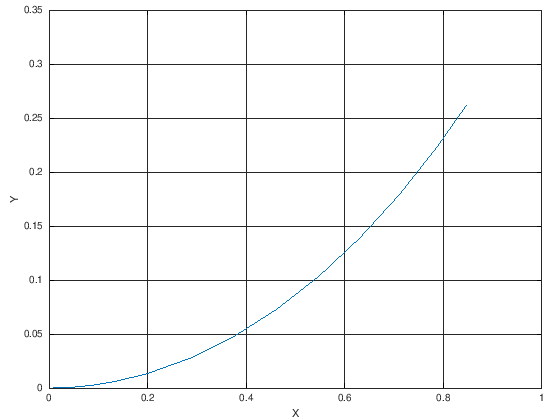

In [6]:
path(uni, 0:dt:3, u)

#### 2.1.7 - Solução Analitica

In [7]:
x_t = @(t,u,x) x(1) + L.*u(1)./u(2) .* (sin(u(2).*t./L + x(3))-sin(x(3)));

y_t = @(t,u,x) x(2) - L.*u(1)./u(2) .* (cos(u(2).*t./L + x(3))-cos(x(3)));

t_t = @(t,u,x) t.*u(2)./L + x(3);

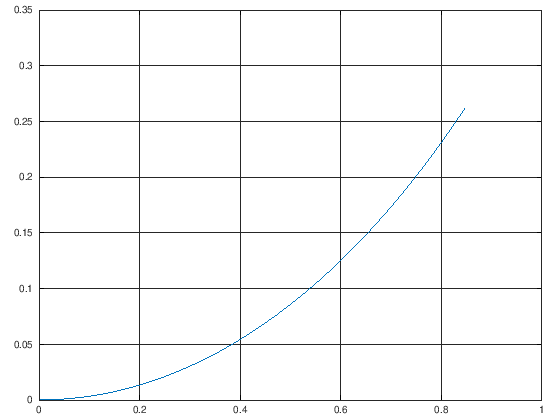

In [8]:
xx = x_t(0:dt:3,u,x);
yy = y_t(0:dt:3,u,x);
plot(xx, yy)
grid on

#### 2.1.8 - Solução Numérica por Euler

In [9]:
function xnext = UnicycleStep(x, u)
    dd = u(1); dth = u(2);
    thp = x(:,3) + dth;
    xnext = x + [dd*cos(thp)  dd*sin(thp) ones(size(x,1),1)*dth];
end 

## 2.2 - Modelo Cinemático de Robôs com Direção Ackermann


<img src="img/fig4_1.svg" width="50%" height="50%">


#### A) Modelo Cinemático com centro de referência no centro do eixo traseiro

#### Figura 3. Reformulando o cálculo de theta para o modelo Ackermann.

<img src="img/ref_rear_theta.png" width="50%" height="50%">

#### Figura 4. O modelo cinemático com centro de referência no centro do eixo traseiro.

<img src="img/ref_rear_ode.png" width="50%" height="50%">

Considerando agora o modelo de direção Ackermann derive as EDO's de posição considerando que a orientação do carro será dada pela equação abaixo e as demais derivadas $dx/dt$ e $dy/dt$ permanecem iguais ao modelo anterior.

$$\dfrac{\partial x}{\partial t}=v(t)cos(\theta)\\\dfrac{\partial y}{\partial t}=v(t)sen(\theta)\\\dfrac{\partial \theta}{\partial t}=\dfrac{v(t)}{L}tan(\delta)\\\dfrac{\partial v}{\partial t}=a$$

#### B) Modelo Cinemático com centro de referência no centro do eixo dianteiro

In [10]:
% Demonstre a trigonometria para se chegar ao modelo com centro de referência no centro do eixo dianteiro abaixo.

#### Figura 5. O modelo cinemático com centro de referência no centro do eixo dianteiro.

<img src="img/ref_front_ode.png" width="50%" height="50%">


#### C) Modelo Cinemático com centro de referência no centro de gravidade

In [11]:
% Demonstre a trigonometria para se chegar ao modelo com centro de referência no centro de gravidade do veículo abaixo.

#### Figura 5. O modelo cinemático com centro de referência no centro de gravidade.

<img src="img/ref_center_ode.png" width="50%" height="50%">

### 2.2.1 - Solução Numerica via EDO's

In [12]:
L = 4.5; % Wheels baseline (default 4.5m)
dt = 0.1; % Time interval (default 0.1)
steermax = pi/6; % Maximum steering (default 0.5 radians);
accelmax = Inf;

In [13]:
addpath('src/trabalho')
car = bicycle(L, accelmax, steermax)

Bicycle: car = <L=4.500000, amax=Inf, smax=0.523599>


In [14]:
% Pag. 123
x = [0 0 0 0]; 
u = [0.5, pi/6];
[x1, u1] = kinematics(car, [], x, u)

x1 =

   0.00000
   0.00000
   0.00000
   0.50000

u1 =

   0.50000   0.52360



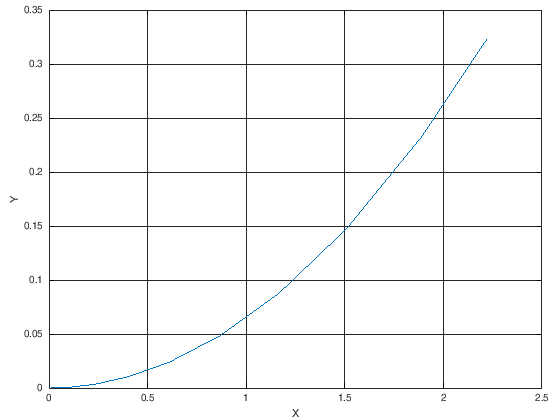

In [15]:
path(car, 0:dt:3, u);

### 2.2.2 - Solução Analitica

In [16]:
% Complete aqui

### 2.2.3 - Solução Numérica por Euler

In [17]:
% Complete aqui

### 2.2.4 - Mudança de Faixa

In [18]:
x = [0 0 0 0]; 
t = 0:0.05:10;
[s,sd,sdd] = lspb(0, 5, t);

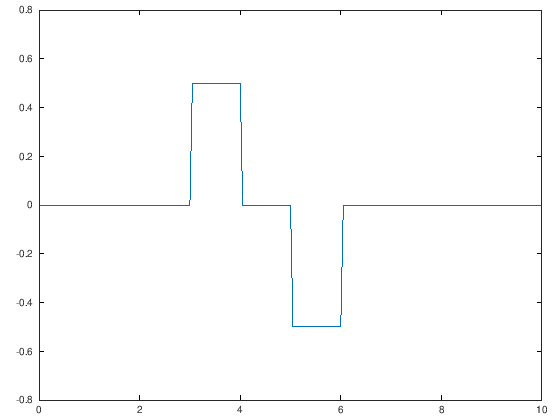

In [19]:
phi = @(t) (t>3) - (t>4) - (t>5) + (t>6);
u = [sdd'; 0.5*phi(t)]';
plot(t, u(:,2))

In [20]:
n = length(t);
yy = [x];
for i=1:n-1
    xx = yy(i,:);
    tt = [t(i) t(i+1)];
    uu = u(i+1,:);
    [T Y] = ode45( @(t,x,u) kinematics(car, t, x, u), tt, xx, uu);
    yy = [yy; Y(end,:)];
end

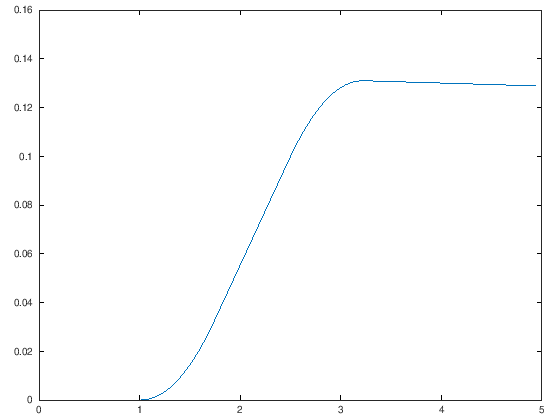

In [21]:
plot(yy(:,1), yy(:,2))

### 2.2.5 - Trajetórias

### 2.2.5.1 - Trajetória Circular (Rotatória)

Plote um círculo com pontos linearmente espaçados cujo raio descreva a trajetório de um veículo com direção Ackermann.

In [22]:
% Complete aqui

### 2.2.5.2 - Trajetória Quadrada (Quarteirão)

Plote os pontos de um quadrado equivalente as dimensões de um quarteirão.

In [23]:
% Complete aqui

### 2.2.5.3 - Trajetória Curvilínea (Pista de corrida)

Plote os pontos de uma trajetória em formato de oito "8" que simule as dimensões de uma pista de corrida.

In [24]:
addpath('src/trabalho')
viapoints = [20 20; -20 40; 0 60; 20 40; -20 20; -0.5 0];
viapoints = mstraj(viapoints, [10,10], [], [0 0], 0.1, 1);
viapoints = [viapoints 10*ones(length(viapoints),1)];

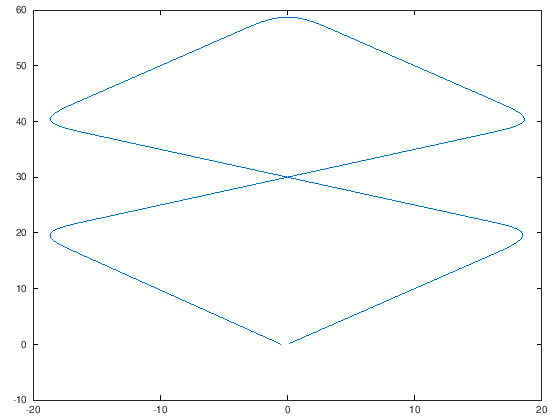

In [25]:
plot(viapoints(:,1), viapoints(:,2));

## Amostragem temporal e espacial

Rode a simulação para as três trajetórias (quarteirão, rotatória, pista de corrida) com diferentes intervalos de distância ($\delta s=1m$, $\delta s=3m$, $\delta s=5m$) entre os waypoints que definem as trajetórias. Para tal verifique se o parâmetro Look-Ahead-Distance do controlador lateral (Pure-Pursuit) dentro da função [main.m](src/trabalho/main.m) é maior que o $\delta s$.

Rode a simulação para as três trajetórias (quarteirão, rotatória, pista de corrida) com diferentes intervalos de tempo $\delta t=\frac{1}{F}$. Onde $F$ é a frequência em Hertz dos três principais sensores utilizados em veículos autônomos: Velodyne LiDAR 32, GPS Trimble e Câmeras.

In [26]:
ds = 1.0;
viapointsXm = viapoints(1,:);
for i = 2:length(viapoints)
    if norm(viapoints(i,1:2)-viapointsXm(end,1:2)) >= ds
        viapointsXm = [viapointsXm; viapoints(i,:)];
    end
end

## 2.3 - Controlador de posição e velocidade

Teste o controlador abaixo nas trajetórias definidas anteriormente para diferentes $\delta t$ e $\delta s$. 

In [27]:
%%time

x = [0 0 0 0]; 
dt = 1/20;
lookahead = 1.0; % look ahead distance (should be greater than ds)
baseline = 4.5; % Wheels baseline (default 4.5m)
accelmax = 9.5; % Tesla Model S (96Km/h em 2.8s)
steermax = 1.22; % Maximum steering (default 0.5 radians);

trajectory = main(x, dt, baseline, accelmax, steermax, lookahead, viapoints);

Time: 35.69363617897034 seconds.



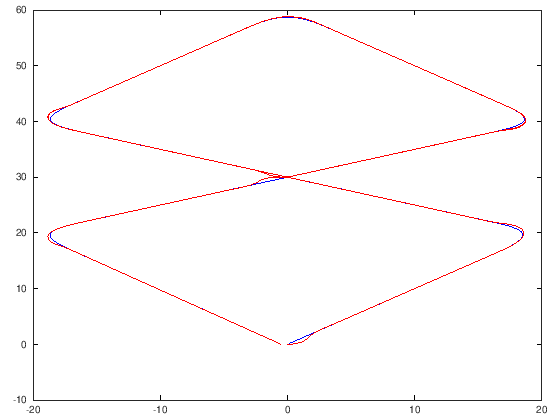

In [28]:
plot(viapoints(:,1), viapoints(:,2), 'b');
hold on
plot(trajectory(:,1), trajectory(:,2), 'r');

### 2.3.1 - Controlador de velocidade (Longitudinal)

<img src="img/pid_control.jpg" width="50%" height="50%">

In [29]:
% Complete aqui

### 2.3.2 - Controlador de posição (Lateral)

<img src="img/pure_pursuit_4.png" width="50%" height="50%">

In [30]:
% Complete aqui

## 2.4 - Análise do Erro Total (Arrendondamento e Truncamento)

Faça uma análise do Erro Total (Arrendondamento e Truncamento) envolvido na aproximação da pose (posição e orientação) de veículos autônomos levando-se em conta as diferentes frequências de amostragem dos sensores comumente utilizados. Plote um gráfico do erro em relação a frequência de amostragem para os erros de arrendondamento e truncamento.

In [31]:
% Complete aqui

## 2.5 - Passos para Implementação em C++

- Observe que o Unreal Engine 4 usa o sistema de coordenadas da mão esquerda, de modo que o eixo X no gráfico é invertido
- Determinar o timestep (delta t) da simulação
- Salvar/Carregar Waypoints
- Obter a posição e velocidade atuais do carro
- Encontre o waypoint mais próximo (próximo) do carro.
- Interpolar Waypoints: como os waypoints são discretos e nosso controlador tem um desempenho melhor com um caminho contínuo, enviaremos um subconjunto dos waypoints a uma certa distância do ponto mais próximo do veículo. A interpolação entre cada waypoint fornecerá um caminho de resolução mais fino e o tornará mais "contínuo". Uma interpolação linear simples é usada como método preliminar para resolver esse problema, embora seja melhor abordada com métodos de interpolação melhores (interpolação por spline, por exemplo).
- Enviar valores atuais do estado do veiculo para o controlador: x, y, theta, velocidade
- Obter comandos do controlador aceleração/throttle (entre 0 e 1), direção/steer (entre -1.22rad e 1.22rad), e freio/brake (entre 0 e 1) 
- Enviar comandos para simulação (ODE)